In [1]:
import numpy as np
from scipy.stats import norm
import pickle as pcl

from keras.models import load_model

%matplotlib inline
import matplotlib
# matplotlib.use('nbAgg')
import matplotlib.pyplot as plt
from matplotlib import rc
from matplotlib import gridspec
rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})
rc('text', usetex=False)

from predict import predict

Using TensorFlow backend.


In [2]:
sim = 'illustris'

si = predict(fname='data/full_histories_%s.h5'%sim)
si.training_mask()
si.filename

'data/full_histories_illustris.h5'

In [3]:
binLimits = si.load_arr('binLimits','bins/log_8')
bins = si.load_arr('bins','bins/log_8')

In [4]:
prediction = {}
predictors = si.load_arr('log_8','SFH')

In [5]:
spec_intr, wl = si.load_spectra('Intrinsic')
spec_intr_noise = si.add_noise_flat(spec=spec_intr, wl=wl, sn=50)
si.generate_standardisation(key='Intrinsic Noise SN50', spec=spec_intr_noise)
features = si.prepare_features(spec_intr_noise, key='Intrinsic Noise SN50', CNN=True)
cnn_model = load_model('data/cnn_trained_%s_intrinsic_noise50_x4.h5'%sim, 
                       custom_objects={'_SMAPE_tf': si._SMAPE_tf})

prediction['intrinsic'] = cnn_model.predict(features[~si.train])

In [6]:
spec_dust, wl = si.load_spectra('Dust')
spec_dust_noise = si.add_noise_flat(spec=spec_dust, wl=wl, sn=50)
si.generate_standardisation(key='Dust Noise SN50', spec=spec_dust_noise)
features = si.prepare_features(spec_dust_noise, key='Dust Noise SN50', CNN=True)

cnn_model = load_model('data/cnn_trained_%s_dust_noise50_x4.h5'%sim, 
                       custom_objects={'_SMAPE_tf': si._SMAPE_tf})

prediction['dust'] = cnn_model.predict(features[~si.train])

## Experimental Errors
Propogate spectral errors through model

In [7]:
sigma = {}

## Intrinsic
cnn_model = load_model('data/cnn_trained_%s_intrinsic_noise50_x4.h5'%sim, 
                       custom_objects={'_SMAPE_tf': si._SMAPE_tf})

pred = si._propogate_uncertainties(cnn_model,key='Intrinsic',N=50,sn=50,
                                   scaler=si.scalers['Intrinsic Noise SN50'])

sigma['intrinsic'], corr = si.calculate_uncertainties(pred)

## Dust
cnn_model = load_model('data/cnn_trained_%s_dust_noise50_x4.h5'%sim, 
                       custom_objects={'_SMAPE_tf': si._SMAPE_tf})

pred = si._propogate_uncertainties(cnn_model,key='Dust',N=50,sn=50,
                                   scaler=si.scalers['Dust Noise SN50'])

sigma['dust'], corr = si.calculate_uncertainties(pred)

/research/astro/highz/Students/Chris/Learning_SFHs/predict.py:395: RuntimeWarning: invalid value encountered in true_divide
  corr = cov / sigma[:,:,None] / sigma[:,None,:]


## Correlation Matrix

In [8]:
## colormap
from matplotlib.colors import LinearSegmentedColormap

def display_cmap(cmap):
    plt.imshow(np.linspace(0, 100, 256)[None, :],  aspect=25,    interpolation='nearest', cmap=cmap) 
    plt.axis('off')

basic_cols=['#75b765', 'black', '#ffd700']
my_cmap=LinearSegmentedColormap.from_list('mycmap', basic_cols)

# set Nan values to red
my_cmap.set_bad((1, 1, 1, 1))

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


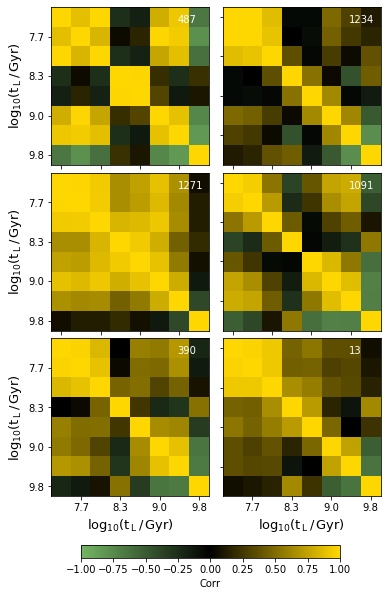

In [9]:
fig, ((ax1,ax2), (ax3,ax4), (ax5,ax6)) = plt.subplots(3, 2, figsize=(6,9))

fig.subplots_adjust(hspace=.05, wspace=.05)

for k,ax in zip([487, 1234, 1271, 1091, 390, 13], [ax1,ax2,ax3,ax4,ax5,ax6]):
    ax.text(0.8, 0.9, k, transform=ax.transAxes, color='white')
    im = ax.imshow(corr[k], cmap=my_cmap, vmin=-1, vmax=1)
    

for ax in [ax1,ax3,ax5]: 
    ax.set_ylabel('$\mathrm{log_{10}(t_{\,L} \,/\, Gyr)}$', size=13)
    ax.set_yticks(np.arange(len(bins))[1::2])
    ax.set_yticklabels(["%.1f"%b for b in bins[1::2]])#, rotation=90);
    
    
for ax in [ax5,ax6]: 
    ax.set_xlabel('$\mathrm{log_{10}(t_{\,L} \,/\, Gyr)}$', size=13)
    ax.set_xticks(np.arange(len(bins))[1::2])
    ax.set_xticklabels(["%.1f"%b for b in bins[1::2]])#, rotation=90);    
    
    
for ax in [ax2,ax4,ax6]:
    ax.set_yticklabels([])
    
    
for ax in [ax1,ax2,ax3,ax4]:
    ax.set_xticklabels([])
    
    
for ax in [ax1,ax2,ax3,ax4,ax5,ax6]:
    ax.set_xlim(-0.5,7.5)
    ax.set_ylim(7.5,-0.5)
    
cax = fig.add_axes([0.2, .03, 0.6, 0.02])
fig.colorbar(im, cax=cax, orientation='horizontal', label='Corr')
    
# fig.savefig('plots/correlation_matrix_example.png', dpi=200, bbox_inches='tight')

## Experimental Errors

In [10]:
experiment_err_fits = {key: [None] * predictors.shape[1] for key in ['dust','intrinsic']}

Fit

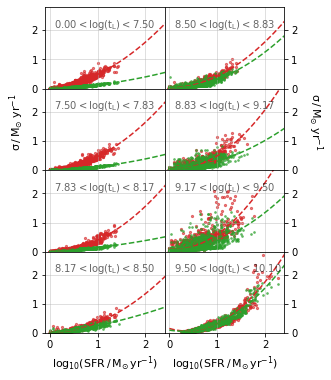

In [17]:
fig = plt.figure(figsize=(5,12))

gs = gridspec.GridSpec(8,7, wspace=0., hspace=0.)

ax1 = plt.subplot(gs[0, :3])
ax2 = plt.subplot(gs[1, :3])
ax3 = plt.subplot(gs[2, :3])
ax4 = plt.subplot(gs[3, :3])
ax5 = plt.subplot(gs[0, 3:6])
ax6 = plt.subplot(gs[1, 3:6])
ax7 = plt.subplot(gs[2, 3:6])
ax8 = plt.subplot(gs[3, 3:6])

axes = [ax1,ax2,ax3,ax4,ax5,ax6,ax7,ax8]

b=np.linspace(-5,5,100)

for i,ax in enumerate(axes):
    
    ax.scatter(np.log10(predictors[~si.train][:,i]+1), sigma['dust'][:,i], 
               s=5, color='C3', alpha=0.6)
    
    ax.scatter(np.log10(predictors[~si.train][:,i]+1), sigma['intrinsic'][:,i], 
               s=3, color='C2', alpha=0.6)
    

    x = np.linspace(0,3,100)
    m2,m1,c = np.polyfit(x=np.log10(predictors[~si.train][:,i]+1), 
                      y=sigma['dust'][:,i], deg=2)
    ax.plot(x, m2*x**2 + m1*x + c, color='C3', linestyle='dashed')
    experiment_err_fits['dust'][i] = [m2,m1,c]

    m2,m1,c = np.polyfit(x=np.log10(predictors[~si.train][:,i]+1), 
                      y=sigma['intrinsic'][:,i], deg=2)
    ax.plot(x, m2*x**2 + m1*x + c, color='C2', linestyle='dashed')
    experiment_err_fits['intrinsic'][i] = [m2,m1,c]
        
    
    ax.set_xlim(-.1, 2.4)
    ax.set_ylim(0,2.8)
    ax.grid(alpha=0.5)
        
    if i not in [3,7]:
        ax.set_xticklabels([])  

    ax.text(0.09, 2.1, '$%.2f < \mathrm{log(t_{L})} < %.2f$'%\
            (np.log10(binLimits[i] * 1e9), np.log10(binLimits[i+1] * 1e9)), alpha=0.6)
    

for ax in [ax5,ax6,ax7,ax8]:
    ax.yaxis.tick_right()
    
for ax in [ax4,ax8]:
    ax.set_xlabel('$\mathrm{log_{10}(SFR \,/\, M_{\odot} \, yr^{-1})}$', size=11)
    

fig.text(0.02, 0.72, '$\mathrm{\sigma \,/\, M_{\odot} \; yr^{-1}}$', rotation=90, size=11)
fig.text(0.85, 0.72, '$\mathrm{\sigma \,/\, M_{\odot} \; yr^{-1}}$', rotation=270, size=11)

# fig.savefig('plots/spectra_errors_%s.png'%sim, dpi=250, bbox_inches='tight')

In [18]:
pcl.dump(experiment_err_fits, open('data/experiment_err_fits_%s.p'%sim,'wb'))

["%.2f    %.2f   %.2f"%(a[0],a[1],a[2]) for a in experiment_err_fits['dust']]

['0.31    0.17   0.00',
 '0.36    0.10   0.01',
 '0.39    -0.02   0.02',
 '0.32    0.03   0.02',
 '0.39    0.01   0.03',
 '0.58    -0.15   0.06',
 '0.63    -0.12   0.09',
 '0.63    -0.47   0.16']

In [19]:
[a[0] for a in experiment_err_fits['dust']]

[0.31211548774948045,
 0.35811266729288865,
 0.3946950266170482,
 0.32160756706780286,
 0.39164286360527983,
 0.5786306880761852,
 0.6324729313098968,
 0.6330429042537046]

## Residuals

Fit to residuals of model to truth, to quantify 'model' error

/research/astro/highz/Students/Chris/Learning_SFHs/venv/lib/python3.6/site-packages/ipykernel_launcher.py:42: RuntimeWarning: divide by zero encountered in log10
/research/astro/highz/Students/Chris/Learning_SFHs/venv/lib/python3.6/site-packages/ipykernel_launcher.py:46: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
/research/astro/highz/Students/Chris/Learning_SFHs/venv/lib/python3.6/site-packages/ipykernel_launcher.py:54: RuntimeWarning: divide by zero encountered in log10
/research/astro/highz/Students/Chris/Learning_SFHs/venv/lib/python3.6/site-packages/ipykernel_launcher.py:58: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.


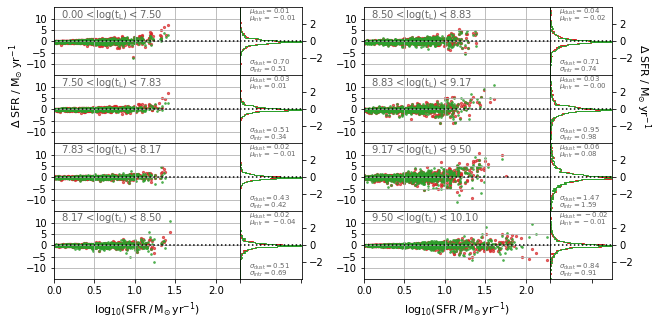

In [23]:
fig = plt.figure(figsize=(10,10))#, dpi=100)

gs = gridspec.GridSpec(8, 9, wspace=0., hspace=0.)

ax1 = plt.subplot(gs[0, :3])
ax1r = plt.subplot(gs[0, 3])

ax2 = plt.subplot(gs[1, :3])
ax2r = plt.subplot(gs[1, 3])

ax3 = plt.subplot(gs[2, :3])
ax3r = plt.subplot(gs[2, 3])

ax4 = plt.subplot(gs[3, :3])
ax4r = plt.subplot(gs[3, 3])

ax5 = plt.subplot(gs[0, 5:8])
ax5r = plt.subplot(gs[0, 8])

ax6 = plt.subplot(gs[1, 5:8])
ax6r = plt.subplot(gs[1, 8])

ax7 = plt.subplot(gs[2, 5:8])
ax7r = plt.subplot(gs[2, 8])

ax8 = plt.subplot(gs[3, 5:8])
ax8r = plt.subplot(gs[3, 8])

axes = [ax1,ax2,ax3,ax4,ax5,ax6,ax7,ax8]
axesr = [ax1r,ax2r,ax3r,ax4r,ax5r,ax6r,ax7r,ax8r]

b=np.linspace(-5,5,100)

# mu = np.array([None] * len(bins))
# sigma = np.array([None] * len(bins))

mu = {key: np.array([None] * predictors.shape[1], dtype=float) for key in ['dust','intrinsic']}
sigma = {key: np.array([None] * predictors.shape[1], dtype=float) for key in ['dust','intrinsic']}

for i, (ax, axr) in enumerate(zip(axes,axesr)):
    
    ax.scatter(np.log10(predictors[~si.train][:,i]), predictors[~si.train][:,i] - prediction['dust'][:,i], 
               s=5, color='C3', alpha=0.7)
    
    n, dumy, dummy = axr.hist(predictors[~si.train][:,i] - prediction['dust'][:,i], 
             histtype='step', bins=b, normed=True, orientation='horizontal', color='C3')
    
    mu['dust'][i], sigma['dust'][i] = norm.fit(predictors[~si.train][:,i] - prediction['dust'][:,i])
    axr.text(0.15, 0.9, '$\mu_{\mathrm{dust}} = %.2f$'%mu['dust'][i], 
             transform=axr.transAxes, size=7, alpha=0.6)
    axr.text(0.15, 0.15, '$\sigma_{\mathrm{dust}} = %.2f$'%sigma['dust'][i], 
             transform=axr.transAxes, size=7, alpha=0.6)
    
    ax.scatter(np.log10(predictors[~si.train][:,i]), predictors[~si.train][:,i] - prediction['intrinsic'][:,i], 
               s=3, color='C2', alpha=0.7)
    
    n, dumy, dummy = axr.hist(predictors[~si.train][:,i] - prediction['intrinsic'][:,i], 
             histtype='step', bins=b, normed=True, orientation='horizontal', color='C2')
    
    mu['intrinsic'][i], sigma['intrinsic'][i] = norm.fit(predictors[~si.train][:,i] - prediction['intrinsic'][:,i])
    axr.text(0.15, 0.8, '$\mu_{\mathrm{intr}} = %.2f$'%mu['intrinsic'][i], 
             transform=axr.transAxes, size=7, alpha=0.6)
    axr.text(0.15, 0.05, '$\sigma_{\mathrm{intr}} = %.2f$'%sigma['intrinsic'][i], 
             transform=axr.transAxes, size=7, alpha=0.6)

    ax.hlines(0, 0, 100, linestyle='dotted')
    
    ax.set_xlim(0, 2.3)#predictors[~sp.train][:,i].max())
    axr.set_xlim(0,n.max())
    
    ax.set_yticks([-10,-5,0,5,10])
    axr.set_yticks([-2,0,2])
    
#     for a in [ax,axr]:
    ax.set_ylim(-15,15)
    axr.set_ylim(-4,4)
        
    if i not in [3,7]:
        for a in [ax,axr]:
            a.set_xticklabels([])
    else:
        axr.set_xticklabels([])
    

    ax.grid()    
    axr.yaxis.tick_right()
    axr.hlines(0, 0, 100, linestyle='dotted')
    
    ax.text(0.09, 10.5, 
            '$%.2f < \mathrm{log(t_{L})} < %.2f$'%(np.log10(binLimits[i]*1e9), np.log10(binLimits[i+1]*1e9)), 
            alpha=0.6)
    
    
for ax in [ax4,ax8]:
    ax.set_xlabel('$\mathrm{log_{10}(SFR \,/\, M_{\odot} \, yr^{-1})}$', size=11)
    

fig.text(0.06, 0.72, '$\Delta \;\mathrm{SFR \;/\; M_{\odot} \; yr^{-1}}$', rotation=90, size=11)
fig.text(0.93, 0.72, '$\Delta \;\mathrm{SFR \;/\; M_{\odot} \; yr^{-1}}$', rotation=270, size=11)

# fig.savefig('plots/residuals_by_mass_%s.png'%sim, dpi=200, bbox_inches='tight')

Fractional residuals

/research/astro/highz/Students/Chris/Learning_SFHs/venv/lib/python3.6/site-packages/ipykernel_launcher.py:46: RuntimeWarning: divide by zero encountered in log10
/research/astro/highz/Students/Chris/Learning_SFHs/venv/lib/python3.6/site-packages/ipykernel_launcher.py:52: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
/research/astro/highz/Students/Chris/Learning_SFHs/venv/lib/python3.6/site-packages/ipykernel_launcher.py:71: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.


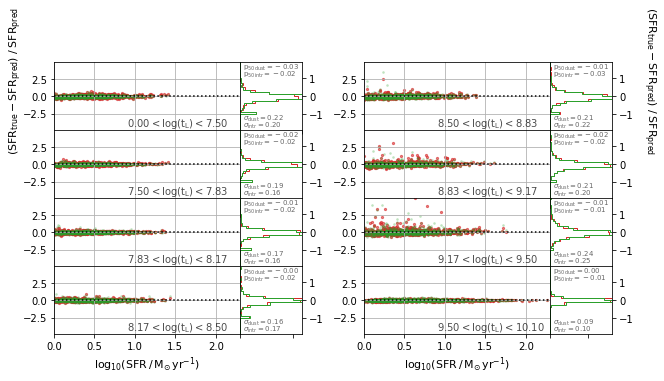

In [26]:
fig = plt.figure(figsize=(10,10))#, dpi=100)

gs = gridspec.GridSpec(8, 9, wspace=0., hspace=0.)

ax1 = plt.subplot(gs[0, :3])
ax1r = plt.subplot(gs[0, 3])

ax2 = plt.subplot(gs[1, :3])
ax2r = plt.subplot(gs[1, 3])

ax3 = plt.subplot(gs[2, :3])
ax3r = plt.subplot(gs[2, 3])

ax4 = plt.subplot(gs[3, :3])
ax4r = plt.subplot(gs[3, 3])

ax5 = plt.subplot(gs[0, 5:8])
ax5r = plt.subplot(gs[0, 8])

ax6 = plt.subplot(gs[1, 5:8])
ax6r = plt.subplot(gs[1, 8])

ax7 = plt.subplot(gs[2, 5:8])
ax7r = plt.subplot(gs[2, 8])

ax8 = plt.subplot(gs[3, 5:8])
ax8r = plt.subplot(gs[3, 8])

# ax9 = plt.subplot(gs[3, 5:8])
# ax9r = plt.subplot(gs[3, 8])

# ax10 = plt.subplot(gs[4, 5:8])
# ax10r = plt.subplot(gs[4, 8])

axes = [ax1,ax2,ax3,ax4,ax5,ax6,ax7,ax8]#,ax9,ax10]
axesr = [ax1r,ax2r,ax3r,ax4r,ax5r,ax6r,ax7r,ax8r]#,ax9r,ax10r]

b=np.linspace(-10,10,161)

mu_model = {key: np.array([None] * predictors.shape[1], dtype=float) for key in ['dust','intrinsic']}
sigma_1_model = {key: np.array([None] * predictors.shape[1], dtype=float) for key in ['dust','intrinsic']}
sigma_2_model = {key: np.array([None] * predictors.shape[1], dtype=float) for key in ['dust','intrinsic']}

for i, (ax, axr) in enumerate(zip(axes,axesr)):
    
    x = np.log10(predictors[~si.train][:,i])
    y = (predictors[~si.train][:,i] - prediction['dust'][:,i]) / prediction['dust'][:,i]
    
    ax.scatter(x, y, s=5, color='C3', alpha=0.6)
    
    n, dumy, dummy = axr.hist(y, histtype='step', bins=b, normed=True, 
                              orientation='horizontal', color='C3')
    
#     mu['dust'][i], sigma['dust'][i] = \
#         norm.fit((predictors[~sp.train][:,i] - prediction['dust'][:,i]) / prediction['dust'][:,i])
    
    mu_model['dust'][i] = np.median(y) # , np.mean(y)
    sigma_1_model['dust'][i] = (np.percentile(y, q=84) - np.percentile(y, q=16)) / 2
    sigma_2_model['dust'][i] = (np.percentile(y, q=97.9) - np.percentile(y, q=2.1)) / 2
    
    axr.text(0.05, 0.9, '$\mathrm{p_{50}}_{\mathrm{dust}} = %.2f$'%mu_model['dust'][i], 
             transform=axr.transAxes, size=7, alpha=0.6)
    axr.text(0.05, 0.15, '$\sigma_{\mathrm{dust}} = %.2f$'%sigma_1_model['dust'][i], 
             transform=axr.transAxes, size=7, alpha=0.6)
    
    y = (predictors[~si.train][:,i] - prediction['intrinsic'][:,i]) / prediction['intrinsic'][:,i]
    
    ax.scatter(x, y, s=3, color='C2', alpha=0.2)
    
    n, dumy, dummy = axr.hist(y, histtype='step', bins=b, normed=True, 
                              orientation='horizontal', color='C2')
    
#     mu['intrinsic'][i], sigma['intrinsic'][i] = \
#       norm.fit(predictors[~sp.train][:,i] - prediction['intrinsic'][:,i])

    mu_model['intrinsic'][i] = np.median(y) # , np.mean(y)
    sigma_1_model['intrinsic'][i] = (np.percentile(y, q=84) - np.percentile(y, q=16)) / 2
    sigma_2_model['intrinsic'][i] = (np.percentile(y, q=97.9) - np.percentile(y, q=2.1)) / 2

    axr.text(0.05, 0.8, '$\mathrm{p_{50}}_{\mathrm{intr}} = %.2f$'%mu_model['intrinsic'][i], 
             transform=axr.transAxes, size=7, alpha=0.6)
    axr.text(0.05, 0.05, '$\sigma_{\mathrm{intr}} = %.2f$'%sigma_1_model['intrinsic'][i], 
             transform=axr.transAxes, size=7, alpha=0.6)

    ax.hlines(0, 0, 100, linestyle='dotted')
    
    ax.set_xlim(0, 2.3)
    axr.set_xlim(0,n.max())
    
#     ax.set_yticks([-5,0,5])
#     axr.set_yticks([-5,0,5])
    
    ax.set_ylim(-4.9,4.9)
    axr.set_ylim(-1.9,1.9)
        
    if i not in [3,7]:
        for a in [ax,axr]:
            a.set_xticklabels([])
    else:
        axr.set_xticklabels([])
    

    ax.grid()    
    axr.yaxis.tick_right()
#     axr.hlines(0, 0, 100, linestyle='dotted')
    
    ax.text(0.9, -4.3, 
            '$%.2f < \mathrm{log(t_{L})} < %.2f$'%(np.log10(binLimits[i]*1e9), np.log10(binLimits[i+1]*1e9)), 
            alpha=0.7)
    

ax8.set_xlabel('$\mathrm{log_{10}(SFR \,/\, M_{\odot} \, yr^{-1})}$', size=11)
ax4.set_xlabel('$\mathrm{log_{10}(SFR \,/\, M_{\odot} \, yr^{-1})}$', size=11)

fig.text(0.06, 0.76, '$\mathrm{(SFR_{true} - SFR_{pred}) \;/\; SFR_{pred}}$', 
         rotation=90, size=11)

fig.text(0.94, 0.76, '$\mathrm{(SFR_{true} - SFR_{pred}) \;/\; SFR_{pred}}$', 
         rotation=270, size=11)

# fig.savefig('plots/fractional_residuals_by_mass_%s.png'%sim, dpi=200, bbox_inches='tight')

In [27]:
pcl.dump(sigma_1_model, open('data/sigma_1_model_%s.p'%sim,'wb'))

["%.3f\n"%sig for sig in sigma_1_model['dust']]

['0.220\n',
 '0.192\n',
 '0.166\n',
 '0.158\n',
 '0.213\n',
 '0.212\n',
 '0.235\n',
 '0.088\n']

## Total Error

In [15]:
def total_error(sfh, experiment_err, model_err, key='intrinsic', fracs=False):
    """
    quadrature sum of model + spectra error
    """
    
    sigma = [None] * len(sfh)
    for i in np.arange(len(sfh)):
        m2,m1,c = experiment_err[key][i]
        sigma[i] = m2*np.log10(sfh[i])**2 + m1*np.log10(sfh[i]) + c
    
    sigma = np.array(sigma)
    # print(sigma)
    # print(sfh * model_err[key])
    
    tot_error = np.sqrt(sigma**2 + (sfh * model_err[key])**2)
    
    if fracs:
        return tot_error, sigma, sfh * model_err[key]
    else:
        return tot_error


## Evaluate Uncertainties

In [16]:


percentile = [si.evaluate_uncertainties(pred[:,i],predictors[~si.train][i]) \
              for i in range(np.sum(~si.train))]
percentile = np.vstack(percentile)

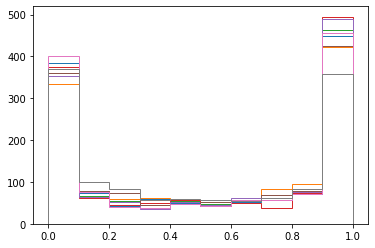

In [17]:
[plt.hist(percentile[:,b], histtype='step') for b in range(8)];

In [18]:
np.sum((percentile > 0.16) & (percentile < 0.84), axis=0) / percentile.shape[0]

array([0.26728827, 0.31002331, 0.29215229, 0.25718726, 0.26651127,
       0.3014763 , 0.25097125, 0.33100233])